# Clasificación de imágenes cancerígenas con redes neuronales

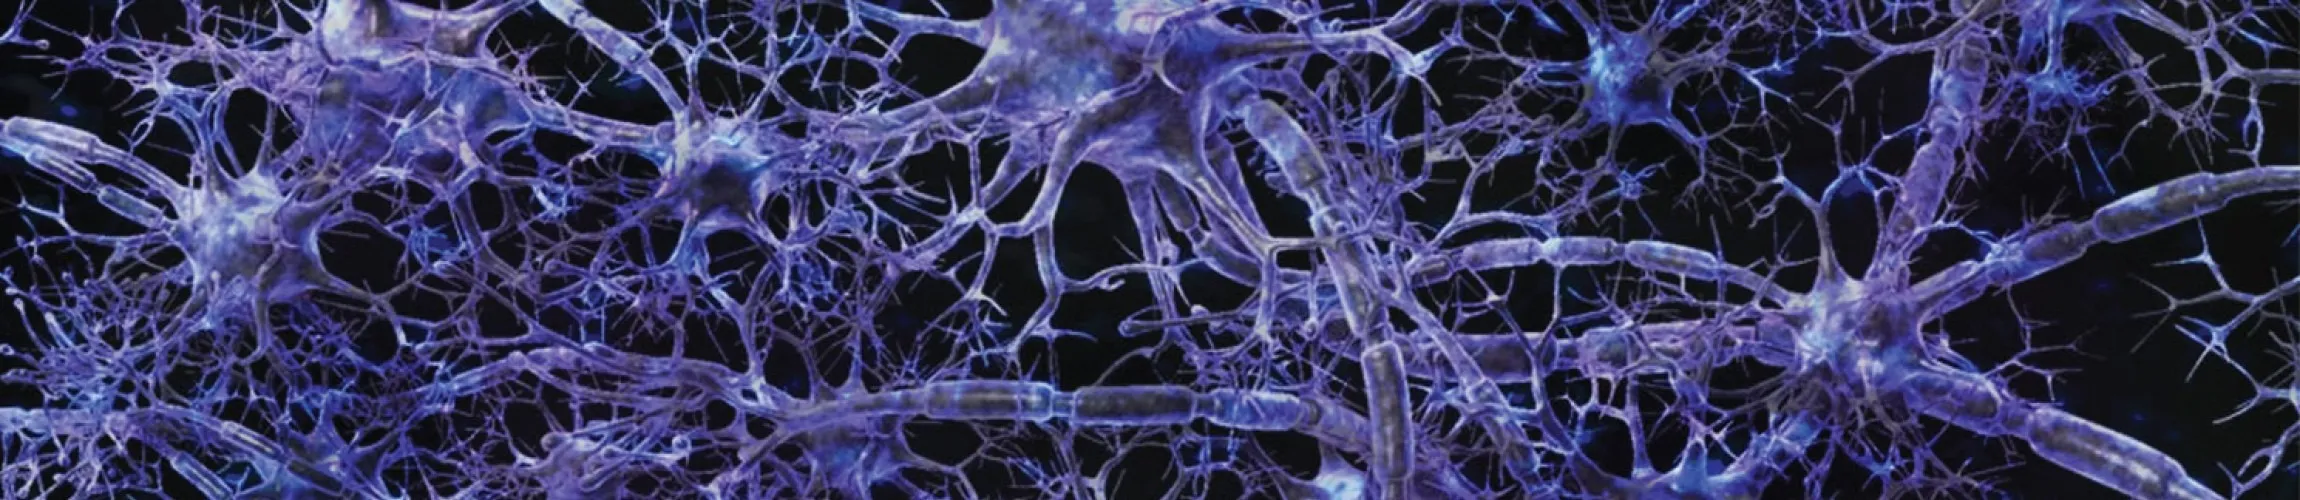

###Trabajo final para el Máster en Big Data & Data Science
Integrantes: Alejandro Gallar y Edgar Cruz

#### **Descripción:**
Este trabajo final se centra en el desarrollo de un sistema innovador para la detección temprana y precisa del cáncer de mama utilizando imágenes de ultrasonidos y técnicas avanzadas de aprendizaje profundo.

#### **Los datos:**
Los datos han sido extraidos de kaggle.com, una web con miles de datos sobre una gran cantidad de áreas. En este caso se corresponden a miles de imágenes de tejido de mama, tanto cancerígeno como no.
Los datos vienen divididas en carpetas cuyo nombre es un identificador (ej. '10275') y hay 134 en total. En el interior de cada una de estas carpetas, se encuentran otras 2, llamadas '0' y '1' para todas ellas. Cada carpeta '1' contiene decenas o cientos de imágenes de tejido cancerígeno y cada carpeta '0' contiene decenas o cientos de imágenes de tejido sano
¿El resultado? Miles y miles de imágenes disponibles de cada tipo, muchas más de las que se pueden computar.


# Importacion de librerías y paquetes

In [2]:
# Para conectarse con la base de datos en drive----------------------------------------------
from google.colab import drive
import os

# Para estructurar los datos-----------------------------------------------------------------
import numpy as np
import pandas as pd

# Para la creación del modelo----------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split # Para separar los datos en test y train

# Para crear una pequeña interfaz------------------------------------------------------------
import ipywidgets as widgets
from IPython.display import display, Image as IPyImage
import io

# Para los outliers--------------------------------------------------------------------------
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor

# Para los graficos--------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Otras librerías----------------------------------------------------------------------------
import torch
import random
from contextlib import redirect_stdout



# Conexión con la base de datos y creación del DataFrame

En este apartado, se realiza la conexión con la base de datos en Drive. El código, conecta el entorno de ejecución con una carpeta en Drive llamada 'TMF_Train' y lee todas las carpetas que haya dentro de esta. Esto permite añadir fácilmente nuevas muestras o eliminar algunas ya existentes. Al leer las carpetas, el código etiqueta cada una de las imágenes que habia dentro de ella con un 0 si estaban en la carpeta '0' y con un 1 si estaban en la carpeta '1'. Con todas estas imagenes y estas etiquetas, finalmente se crea el DataFrame.

In [3]:
# Conectamos el entorno con Drive y definimos la ruta
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/TFM_Train' #Ruta hacia las imagenes para el consumo del modelo (1)

# Creamos dos listas, una para guardas las rutas de las imágenes y otra para las etiquetas
image_paths = []
labels = []

# Recorremos todas las carpetas una a una en caso de que exista la ruta
for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder)
    if os.path.isdir(folder_path):
        non_cancer_folder = os.path.join(folder_path, '0') # Definimos la carpeta con las imagenes sanas
        cancer_folder = os.path.join(folder_path, '1') # Definimos la carpeta con las imagenes infectadas

        # Cargamos ahora en nuestras listas las imagenes sanas y cancerígenas junto con sus respectivos labels en las dos listas que creamos anteriormente
        for filename in os.listdir(non_cancer_folder):
            image_path = os.path.join(non_cancer_folder, filename)
            image_paths.append(image_path)
            labels.append(0)
        for filename in os.listdir(cancer_folder):
            image_path = os.path.join(cancer_folder, filename)
            image_paths.append(image_path)
            labels.append(1)

# Finalmente creamos el DataFrame utilizando estas dos listas
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

Mounted at /content/drive


# Visualización de las imágenes

En este apartado se muestran 5 imágenes de cada tipo, para tener un ejemplo de como son las imágenes que se van a tratar y mejorar el entendimiento con el problema. Se pueden visualizar diferentes imágenes cambiando el índice del DataFrame.

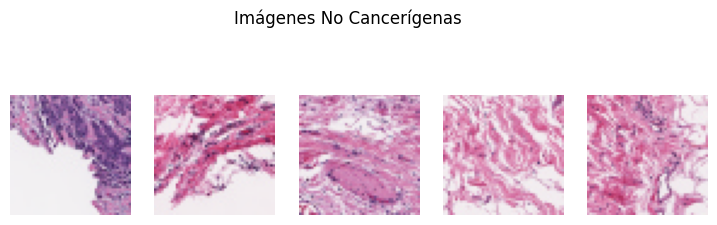

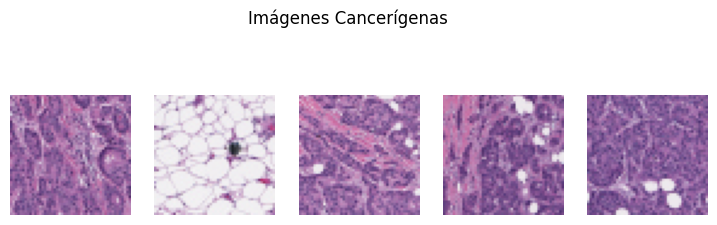

In [4]:
# Seleccionar las imágenes que queremos imprimir
non_cancer_images = data[data['label'] == 0].iloc[20:25] # Cambiar este ratio para ver otras imágenes
cancer_images = data[data['label'] == 1].iloc[5:10] # Cambiar este ratio para ver otras imágenes

# Mostramos las 5 imágenes no cancerígenas
plt.figure(figsize=(9, 3)) # Tamaño de las imagenes
plt.suptitle('Imágenes No Cancerígenas', fontsize=12)  # Título general
for index, (_, row) in enumerate(non_cancer_images.iterrows()):
    image_path = row['image_path']
    image = Image.open(image_path)
    plt.subplot(1, 5, index + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Mostramos las  5 imágenes cancerígenas
plt.figure(figsize=(9, 3)) # Tamaño de las imagenes
plt.suptitle('Imágenes Cancerígenas', fontsize=12)  # Título general
for index, (_, row) in enumerate(cancer_images.iterrows()):
    image_path = row['image_path']
    image = Image.open(image_path)
    plt.subplot(1, 5, index + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Dimensiones
Podemos ver las dimensiones del dataframe resultante de combinar todas las imágenes de las carpetas que estaban en la ruta del Drive y el numero de ellas que pertenecen a un grupo o al otro.

In [5]:
print("Dimensiones del DataFrame: ", data.shape) # Dimensiones

image_counts = data['label'].value_counts() # Recuento de imágenes de cada tipo
print("Cantidad de imágenes no cancerígenas (0): ", image_counts[0])
print("Cantidad de imágenes cancerígenas (1): ", image_counts[1])

Dimensiones del DataFrame:  (3524, 2)
Cantidad de imágenes no cancerígenas (0):  2009
Cantidad de imágenes cancerígenas (1):  1515


# Analisis de outliers

Existen varias imágenes cuyas características se separan bastante del conjunto inicial y pueden no ser de mucha utilidad para el modelo debido a contenido vacío o iterferencias y por ello, vamos a realizar un analisis de outliers.


#### Utilizamos GPU para aumentar eficiencia

Antes de procesar los datos en el modelo y empezar a realizar predicciones, es importante estar utilizando la GPU para que los procesos sean más eficientes. En esta caso se esta utilizando un modulo de GPU V100, que permite computar una cantidad considerable de estas imágenes (4000) en un tiempo de 30 minutos.

In [7]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    device = torch .device('cuda')
    print('Training on GPU.')
else:
    device = torch.device('cpu')
    print('No GPU available, training on CPU.')

Training on GPU.


## Local Outlier Factor

Para tratar de encontrar imágenes con interferencias, una baja cantidad de información o con una dierencia grande en el dataset, vamos a aplicar un algortimo llamado Local Outlier Factor, que calcula la densidad local en un conjunto de vecinos para detectar valores atípicos. Este algoritmo calcula un valor pro cada una de las imágenes, si el valor es mayor que 1, probablemente sea un outlier, un valor de aproximadamente 1 corresponde a un valor normal y finalmente un valor inferior a 1 tambien es probablemente un outlier, pero este caso es inusual en la mayoria de las situaciones.

Lo que haremos será coger el 2.5% de los valores calculados por el LOF más altos ya que son los que el algoritmo considera como más atipicos.

In [8]:
# Creamos una función para procesar las imagenes
def process_images(image_path):
    img = Image.open(image_path).convert('RGB') # La convertimos en RGB en caso de que no lo sea
    img = img.resize((224, 224))  # Redimensionamos las imágenes a un tamaño compatible con VGG19 (224x224)
    img_array = np.array(img) / 255.0
    return img_array

# La aplicamos en el dataframe
data['image_array'] = data['image_path'].apply(process_images)

# Supongamos que 'data' es tu DataFrame con la columna 'image_array' ya creada
X = np.stack(data['image_array'].values)  # Convertimos las listas de arrays en un array 2D

# Reshape para que tenga la forma adecuada para VGG19 (batch_size, height, width, channels)
X = X.reshape(-1, 224, 224, 3)

# Aplanamos para obtener un array 2D (batch_size, feature_size)
X = X.reshape(X.shape[0], -1)

# Inicializa el modelo LOF
lof = LocalOutlierFactor(contamination=0.025)

# Calcula los outliers
outliers = lof.fit_predict(X)

# Añade los resultados al DataFrame original
data['lof_score'] = lof.negative_outlier_factor_

# Filtra los datos para obtener el 2.5% de los resultados más altos
top_2_5_percent = data.nlargest(int(0.025 * len(data)), 'lof_score')

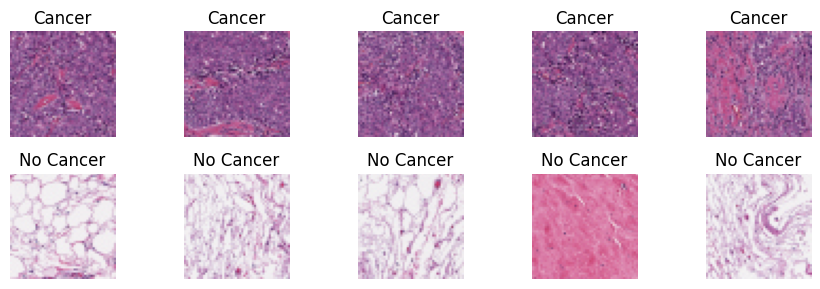

In [10]:
selected_cancer_paths = top_2_5_percent[top_2_5_percent['label'] == 1]['image_path'].head(5)
selected_non_cancer_paths = top_2_5_percent[top_2_5_percent['label'] == 0]['image_path'].head(5)

# Imágenes cancerígenas
plt.figure(figsize=(9, 3))
for i, img_path in enumerate(selected_cancer_paths):
    plt.subplot(2, 5, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title('Cancer')
    plt.axis('off')

# Imágenes no cancerígenas
for i, img_path in enumerate(selected_non_cancer_paths):
    plt.subplot(2, 5, 5 + i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title('No Cancer')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
len(top_2_5_percent[top_2_5_percent['label'] == 1]['image_path']), len(top_2_5_percent[top_2_5_percent['label'] == 0]['image_path']),

(26, 62)

## Desviacion estandar media

Para tratar los outliers desde otra perspectiva, utilizaremos una tecnica más sencilla y es considerar las imágenes como outliers en caso de que su desviacion estandar se aleje mas de 1.4 veces de la media del conjunto, este valor se ha decidido en base a varios testos y un valor superior delimita el estudio a muy pocos outliers.

Esta es una tecnica muy simple, pero queremos comprobar que impácto puede tener en este analisis, como podemos ver en el siguiente trozo de código, el número de outliers detectado es de 93, donde un 21.5% de los outliers detectados son de tipo cancerigeno y el 78.5% restante son de imágenes no cancerigenas.

In [14]:
# Calculamos la desviación estándar de todas las imágenes
std_dev_all_images = data['image_path'].apply(lambda x: np.std(np.array(Image.open(x))))

# Luego calculamos la desviación estándar media del conjunto
mean_std_dev = std_dev_all_images.mean()

# Definimos el umbral basado en 1.4 veces la desviación estándar media
umbral = 1.4 * mean_std_dev

# Creamos una columna para identificar outliers
data['label_outlier'] = (std_dev_all_images > umbral).astype(int)

# Contamos cuántos outliers son cancerígenos y cuántos no cancerígenos
num_cancer_outliers = (data['label_outlier'] == 1) & (data['label'] == 1)
num_non_cancer_outliers = (data['label_outlier'] == 1) & (data['label'] == 0)

print(f'Número de outliers cancerígenos: {num_cancer_outliers.sum()}')
print(f'Número de outliers no cancerígenos: {num_non_cancer_outliers.sum()}')


Número de outliers cancerígenos: 20
Número de outliers no cancerígenos: 73


In [21]:
data_stdv = data[data['label_outlier']==1]
coincidencias = top_2_5_percent['image_path'].isin(data_stdv['image_path'])

sum(coincidencias)

0

Para tener una idea de como son estos outliers, vamos a visualizar nuevamente 5 de cada tipo, para poder tambien compararlos con la muestra del conjunto inicial.

En principio los resultados parece ser mejores, se ha detectado un numero mucho mas pequeño de outliers que utilizando PCA, pero podemos ver que en este grupo reducido de imágenes si hay características que las podrían separar del conjunto principal, como cambios bruscos en el color o zonas muy grandes sin información.

Personalmente, consideramos que es mejor aplicar esta tecnica basada en las desviación estandar media, ya que no se compromete una gran cantidad de datos y es probable que una limpieza de estas imágenes para el dataframe que será consumido por el modelo puede mejorar los resultados.

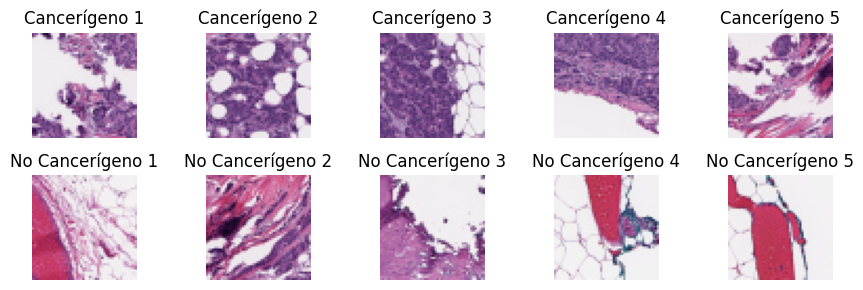

In [ ]:
# Mostramos 5 imágenes de outliers cancerígenos
num_images_to_show = 5
plt.figure(figsize=(9, 3))

for i, idx in enumerate(data[num_cancer_outliers].index[:num_images_to_show]):
    image_path = data.loc[idx, 'image_path']
    img = Image.open(image_path)

    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f'Cancerígeno {i + 1}')
    plt.axis('off')

# Mostramos 5 imágenes de outliers no cancerígenos
for i, idx in enumerate(data[num_non_cancer_outliers].index[5:num_images_to_show+5]):
    image_path = data.loc[idx, 'image_path']
    img = Image.open(image_path)

    plt.subplot(2, num_images_to_show, num_images_to_show + i + 1)
    plt.imshow(img)
    plt.title(f'No Cancerígeno {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Con lo comentado anteriormente, eliminamos los outliers del dataframe y lo comprobamos imprimiendo la forma del dataframe.

In [ ]:
# Identificamos los índices de los outliers y los eliminamos del dataframe
outlier_indices_cancer = data[(data['label_outlier'] == 1) & (data['label'] == 1)].index
outlier_indices_non_cancer = data[(data['label_outlier'] == 1) & (data['label'] == 0)].index
data= data.drop(outlier_indices_cancer.union(outlier_indices_non_cancer))
print(f'Tamaño del DataFrame después de eliminar outliers: {data.shape}')

Tamaño del DataFrame después de eliminar outliers: (3431, 4)


# Modelo de red neuronal VGG19

El tipo de tecnologia que vamos a utilizar para realizar la clasificación es de tipo red neuronal, especificamente vamos a cargar una arquitectura ya construida, en este caso VGG19, ya que ha demostrado ser mucho más eficientes con la detección de caracteristicas y la clasificación en si.

#### Entorno con GPU

Es una buena práctica comprobar si la GPU sigue disponible antes de accionar código que require de una computación alta.

In [ ]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    device = torch.device('cuda')
    print('Training on GPU.')
else:
    device = torch.device('cpu')
    print('No GPU available, training on CPU.')

Training on GPU.


#### Creación del modelo

En este trozo de código se crea y compila el modelo asi como se entrena con los datos procesados anteriormente. La arquitectura es simple con una capa personalizada de 128 nodos, conectada a la arquitectura VGG19 y la salida del sistema representada en porcentaje (100% cuando la imagén sea cancerígena y 0% cuando no lo sea)

In [ ]:
# Creamos una función procesar las imagenes
def process_images(image_path):
    img = Image.open(image_path).convert('RGB') # La convertimos en RGB en caso de que no lo sea
    img = img.resize((224, 224))  # Redimensionamos las imágenes a un tamaño compatible con VGG19 (224x224)
    img_array = np.array(img) / 255.0
    return img_array

# Aplicamos la función en los datos y los dividimos en entrenamiento y prueba
data['image'] = data['image_path'].apply(process_images)
X_train, X_test, y_train, y_test = train_test_split(data['image'], data['label'], test_size=0.2, random_state=42)

# Convertimos todos los datos en numpy para que puedan ser consumidos por el modelo
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())
y_train = np.array(y_train.tolist())
y_test = np.array(y_test.tolist())

# Cargamos la arquitectura pre-entrenada VGG19 (sin incluir las capas fully connected/top layers)
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Agregar capas fully connected/top layers personalizadas
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Congelamos las capas del modelo base (VGG19) para que no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Finalmente, creamos, compilamos y entremos el modelo
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
86/86 [==============================] - 19s 210ms/step - loss: 0.5788 - accuracy: 0.8174 - val_loss: 0.3061 - val_accuracy: 0.8734
Epoch 2/10
86/86 [==============================] - 17s 202ms/step - loss: 0.2837 - accuracy: 0.8856 - val_loss: 0.2837 - val_accuracy: 0.8836
Epoch 3/10
86/86 [==============================] - 17s 195ms/step - loss: 0.2059 - accuracy: 0.9187 - val_loss: 0.2848 - val_accuracy: 0.8894
Epoch 4/10
86/86 [==============================] - 16s 190ms/step - loss: 0.1765 - accuracy: 0.9326 - val_loss: 0.2856 - val_accuracy: 0.8937
Epoch 5/10
86/86 [==============================] - 16s 190ms/step - loss: 0.2036 - accuracy: 0.9176 - val_loss: 0.4761 - val_accuracy: 0.8384
Epoch 6/10
86/86 [==============================] - 17s 193ms/step - loss: 0.1608 - accuracy: 0.9406 - val_loss: 0.3155 - val_accuracy: 0.8836
Epoch 7/10
86/86 [==============================] - 17s 196ms/step - loss: 0.1081 - accuracy: 0.9621 - val_loss: 0.3115 - val_accuracy: 0.8967

# Visualización de Loss, Accuracy y Validation accuracy

A continuación, la representación visual de las características del modelo.

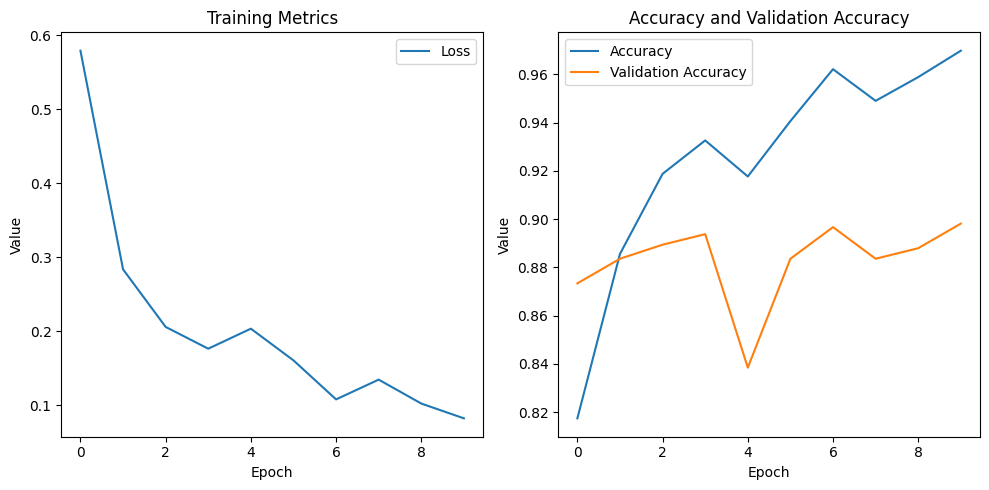

In [ ]:
# Creamos el espacio de figuras
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')

# Definimos labels y leyenda
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Metrics')

# Ploteamos los resultados
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Accuracy and Validation Accuracy')

plt.tight_layout()
plt.show()

# Test de fiabilidad 1

Como se menciona al principio del ejercicio, para este proyecto existen 134 muestras o carpetas (cuyo nombre es un identificador, ej. '08093') y cada una de estas contiene otras dos carpetas llamadas '0' y '1' con imagenes de negativos y positivos respectivamente. No obstante, a pesar de utilizar una GPU V100, solo hemos podido computar 3 de estas 134 carpetas, lo que deja una gran libertad para realizar diversas pruebas, y comprobar la eficacia del modelo.

En esta prueba se extraen 10 imágenes aleatorias cancerígenas y 10 no cancerígenas de cada una de las 3 carpetas destinadas para el test. Estas imágenes son consumidas por el modelo y al final se obtiene un score sobre 10, entonces este proceso se repite 10 veces para cada carpeta y se hace la media de los aciertos.

Para un mayor entendimiento, proponemos un ejemplo: Tenemos una carpeta llamada '10756', esta contiene otras dos la carpeta '0' y la carpeta '1'. De cada una de estas carpetas se extraen 10 imágenes aleatorias, se realizan predicciones sobre ellas y con ello obtenemos un score. Digamos que de la carpeta '0' se acertaron como no cancerigenas 7/10 y que en la carpeta '1' fueron 8/10. Este proceso se repetira 10 veces mas , de manera que podemos hacer una media de estos 10 scores que salen en el proceso. Esto se hace para todas las carpetas que formen el test y el resultado es la media de aciertos por carpeta y por categoria de imagen.


In [ ]:
# Desactivamos los mensajes de progreso de TensorFlow (ya que se procesan 600 imagenes)
tf.get_logger().setLevel('ERROR')
test_folder = '/content/drive/MyDrive/TFM_test' #Ruta hacia las imagenes para el consumo del modelo (2)

def process_images(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    return img_array


num_images_per_category = 10
num_trials = 10 # Número de veces que se repetirá el proceso

# Inicializamos variables para llevar un registro de los resultados
results_cancerous = []
results_non_cancerous = []

p_cancer = []
p_no_cancer = []

# Suprimimos la salida de predicciones ya que son 600
null_io = io.StringIO()

with redirect_stdout(null_io):
    # Creamos el loop que se repetira 10 veces en este caso
    for _ in range(num_trials):
      #Creamos las carpetas para las pruebas individuales
        num_correct_cancerous_trials = []
        num_correct_non_cancerous_trials = []

        # Iteramos sobre las carpetas que se encuentren en el repositorio si las hay
        for folder_name in os.listdir(test_folder):
            folder_path = os.path.join(test_folder, folder_name)
            if os.path.isdir(folder_path):
              # Creamos las variables para hacer el recuento de aciertos
                num_correct_cancerous_folder = 0
                num_correct_non_cancerous_folder = 0
                # Iteramos sobre las subcarpetas '0' y '1' de cada carpeta
                for subfolder_name in os.listdir(folder_path):
                    subfolder_path = os.path.join(folder_path, subfolder_name)
                    if os.path.isdir(subfolder_path):
                        image_files = os.listdir(subfolder_path)
                        # Escogemos las imágenes de manera aleatoria
                        selected_images = random.sample(image_files, num_images_per_category)
                        # Predecimos sobre las imagenes aleatorias
                        for image_file in selected_images:
                            image_path = os.path.join(subfolder_path, image_file)
                            processed_image = process_images(image_path)
                            prediction = model.predict(np.expand_dims(processed_image, axis=0))
                            predicted_label = 1 if prediction > 0.5 else 0
                            actual_label = int(subfolder_name)
                            # Calculamos el número de aciertos y fallos
                            if actual_label == 0: p_no_cancer.append(prediction)
                            if actual_label == 1: p_cancer.append(prediction)
                            if predicted_label == actual_label:
                                if actual_label == 1:
                                    num_correct_cancerous_folder += 1
                                else:
                                    num_correct_non_cancerous_folder += 1
                # Guardamos los resultados individuales
                num_correct_cancerous_trials.append(num_correct_cancerous_folder)
                num_correct_non_cancerous_trials.append(num_correct_non_cancerous_folder)
        # Guardamos los resultados colectivos
        results_cancerous.append(num_correct_cancerous_trials)
        results_non_cancerous.append(num_correct_non_cancerous_trials)

# Finalmente calculamos las medias de los resultados por carpeta
avg_results_cancerous = np.mean(results_cancerous, axis=0)
avg_results_non_cancerous = np.mean(results_non_cancerous, axis=0)

A continuación se puede ver una representación gráfica de los resultados de los aciertos por carpeta y por categoría.

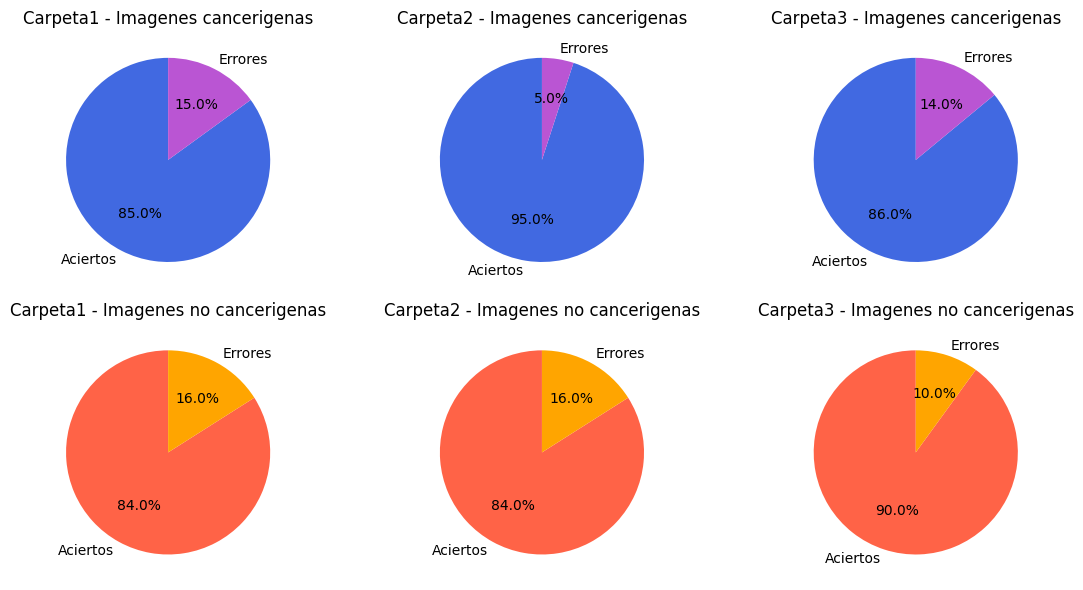

In [ ]:
# Definimos la paleta de colores para los graficos
colors_cancerous = ['royalblue', 'mediumorchid']
colors_non_cancerous = ['tomato', 'orange']

# Definimos los labels
labels = ['Carpeta1 - Imagenes cancerigenas', 'Carpeta2 - Imagenes cancerigenas', 'Carpeta3 - Imagenes cancerigenas']
labels2 = ['Carpeta1 - Imagenes no cancerigenas', 'Carpeta2 - Imagenes no cancerigenas', 'Carpeta3 - Imagenes no cancerigenas']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # Creamos 2 filas de 3 gráficos
# Creamos gráficos circulares para los resultados cancerigenos
for i in range(3):
    sizes = [avg_results_cancerous[i], 10 - avg_results_cancerous[i]]
    axes[0, i].pie(sizes, labels=['Aciertos', 'Errores'], autopct='%1.1f%%', startangle=90, colors=colors_cancerous)
    axes[0, i].set_title(labels[i])

# Creamos gráficos circulares para los resultados no cancerigenos
for i in range(3):
    sizes = [avg_results_non_cancerous[i], 10 - avg_results_non_cancerous[i]]
    axes[1, i].pie(sizes, labels=['Aciertos', 'Errores'], autopct='%1.1f%%', startangle=90, colors=colors_non_cancerous)
    axes[1, i].set_title(labels2[i])

plt.tight_layout()
plt.show()

# Test de fiabilidad 2

Vamos a realizar una segunda prueba para comprobar de nuevo la calidad del modelo, para ello, vamos a realizar predicciones sobre todas las imágenes de las carpetas de prueba, separando los resultados para las imagenes cancerigenas por un lado y para las no cancerigenas por otro. Esto nos permite realizar una gráfica en la que podemos ver los porcentajes de precisión del modelo para cada imágen de manera ordenada, por lo que podemos ver la evolución de las predicciones para todas las muestras.


In [ ]:
# Desactivamos los mensajes de progreso de TensorFlow (ya que se procesan muchas imágenes)
tf.get_logger().setLevel('ERROR')
test_folder = '/content/drive/MyDrive/TFM_test'  # Ruta hacia las imágenes para el consumo del modelo (2)

num_trials = 1  # Número de veces que se repetirá el proceso

# Inicializamos listas para guardar las probabilidades de acierto
predictions_cancerous = []
predictions_non_cancerous = []

# Suprimir la salida de predicciones
null_io = io.StringIO()

with redirect_stdout(null_io):
    for _ in range(num_trials):
        # Abrimos las carpetas en caso de que hayan
        for folder_name in os.listdir(test_folder):
            folder_path = os.path.join(test_folder, folder_name)
            # Abrimos las subcarpetas '0' y '1'
            if os.path.isdir(folder_path):
                for subfolder_name in os.listdir(folder_path):
                    subfolder_path = os.path.join(folder_path, subfolder_name)
                    if os.path.isdir(subfolder_path):
                        # Guardamos las rutas de las imagenes en una variable
                        image_files = os.listdir(subfolder_path)
                        for image_file in image_files:
                            image_path = os.path.join(subfolder_path, image_file)
                            # Procesamos las imagenes a partir de la ruta una a una
                            processed_image = process_images(image_path)
                            # Realizamos las predicciones
                            prediction = model.predict(np.expand_dims(processed_image, axis=0))
                            predicted_probability = prediction[0][0]  # Probabilidad de la clase 1
                            # Finalmente, guardamos la predicción en el vector correspondiente
                            if int(subfolder_name) == 1:
                                predictions_cancerous.append(predicted_probability)
                            else:
                                predictions_non_cancerous.append(predicted_probability)

Con los vectores de probabilidades creados, ahora podemos graficar los resultados.

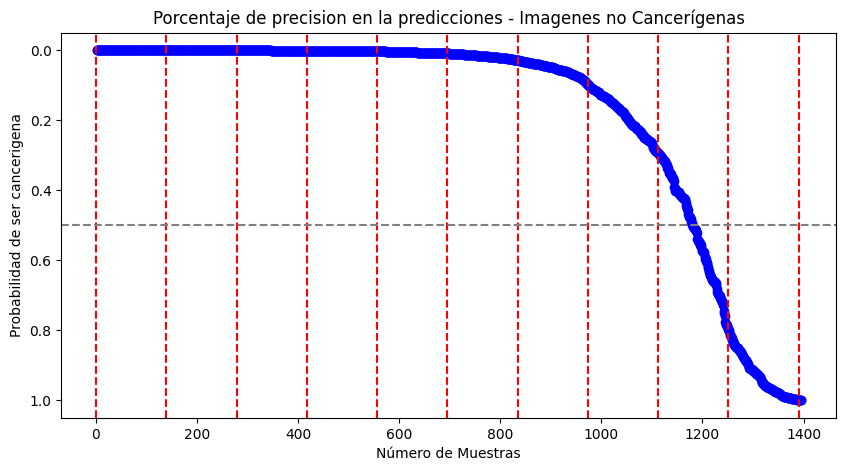

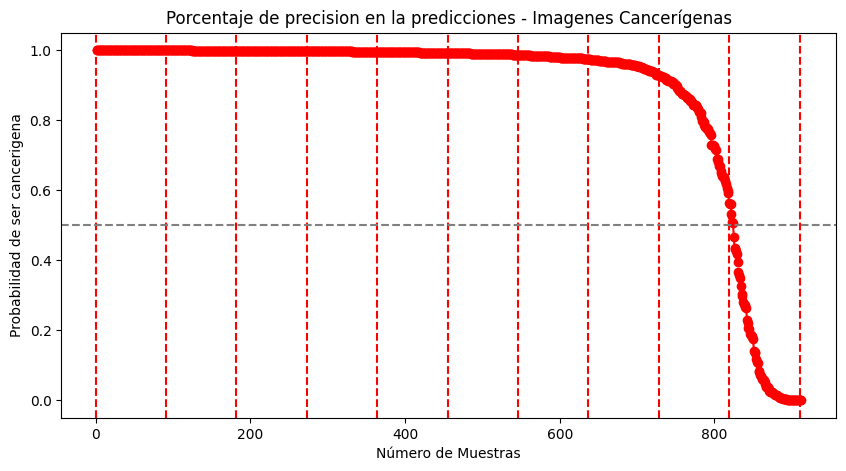

In [ ]:
# Ordenamos los valores de los vectores de mayor a menor
sorted_non_cancerous = np.sort(np.array(predictions_non_cancerous))[::-1]
sorted_cancerous = np.sort(np.array(predictions_cancerous))[::-1]

# Creamos vectores con el tamaño de las muestras para el eje x
num_muestras1 = range(1, len(predictions_cancerous) + 1)
num_muestras2 = range(1, len(predictions_non_cancerous) + 1)[::-1]

# Creamos valores para dividir las graficas en deciles
x = int(len(predictions_non_cancerous)/10)
x1 = 0
y = int(len(predictions_cancerous)/10)
y1 = 0

# Creamos el gráfico de línea de puntos para las predicciones sobre imágenes no cancerígenas
plt.figure(figsize=(10, 5))
# Determinamos como se veran los valores en el plot
plt.plot(num_muestras2, sorted_non_cancerous, linestyle='--', marker='o', label='Probabilidades No Cancerosas', color='blue')
# Definimos los labels
plt.xlabel('Número de Muestras')
plt.ylabel('Probabilidad de ser cancerigena')
plt.title('Porcentaje de precision en la predicciones - Imagenes no Cancerígenas')
# Utilizamos el bucle for para imprimir las lineas que dividen la grafica en deciles
for i in range(11):
  plt.axvline(x=x1, color='red', linestyle='--', label= f'Decil {i+1}')
  x1 = x1 + x
plt.axhline(y=0.5, color='gray', linestyle='--', label='Valor 0.5')
plt.gca().invert_yaxis()  # Invertir el eje y
plt.show()

# Creamos el gráfico de línea de puntos para las predicciones sobre imagenes cancerigenas
plt.figure(figsize=(10, 5))
# Determinamos como se veran los valores en el plot
plt.plot(num_muestras1, sorted_cancerous, linestyle='--', marker='o', label='Probabilidades Cancerosas', color='red')
# Definimos los labels
plt.xlabel('Número de Muestras')
plt.ylabel('Probabilidad de ser cancerigena')
plt.title('Porcentaje de precision en la predicciones - Imagenes Cancerígenas')
# Utilizamos el bucle for para imprimir las lineas que dividen la grafica en deciles
for j in range(11):
  plt.axvline(x=y1, color='red', linestyle='--', label= f'Decil {j+1}')
  y1 = y1 + y
plt.axhline(y=0.5, color='gray', linestyle='--', label='Valor 0.5')
plt.show()

# Interfaz gráfica

Para poder interaccionar con el modelo de una forma más simple, hemos creado una pequeña interfaz gráfica que permite elegir una imágen del dataset de manera local, para que el modelo la clasifique directamente. Esto ayuda a realizar pruebas en un principio para poder ajustar parámetros o cambiar características y por otro lado sirve como una pequeña aplicación en la que basarse.

In [ ]:

# Creamos una función para cargar y procesar la imagen al subirla
def load_and_process_image(file_path):
    img = Image.open(io.BytesIO(file_path))
    img = img.resize((224, 224))  # Redimensionar la imagen a un tamaño fijo
    img_array = np.array(img) / 255.0  # Normalizar los valores de píxeles en el rango [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Agregar una dimensión para el lote (batch) de la imagen
    return img_array

# Creamos una función para procesar la imagen cargada y mostrar el resultado
def process_uploaded_image(change):
    if change['new']:
        file_path = next(iter(change['new']))
        # Utilizamos la función de procesar creada anteriormente
        processed_image = load_and_process_image(change['new'][file_path]['content'])
        prediction = model.predict(processed_image)[0][0]
        probability = round(prediction, 2)

        # Mostramos la imagen visualmente en el recuadro
        image = Image.open(io.BytesIO(change['new'][file_path]['content']))
        with output_image:
            display(image)

        # Mostramos el resultado de la predicción
        if probability >= 0.5:
            result_label.value = f'Probabilidad de ser cancerígena: {probability}'
        else:
            result_label.value = f'Probabilidad de no ser cancerígena: {1 - probability}'

# Creamos el boton que nos permite cargar la imágen
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(process_uploaded_image, names='value')

# Creamos un recuadro para mostrar la imagen visualmente
output_image = widgets.Output()

# Definimos la etiqueta para mostrar el resultado de la predicción
result_label = widgets.Label()

# Finalmente, ejecutamos los elementos para desarrollar
display(widgets.VBox([uploader, output_image, result_label]))


1/1 [==============================] - 0s 21ms/step
